#Импортируем всякое

In [63]:
import pandas as pd
import numpy as np
import math
from copy import deepcopy

import scipy
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import mstats
from scipy.stats import t, chi2, f, norm, poisson, binom, uniform, expon, logistic

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

#Генерируем данные

Нам необходимо сгенерировать 7 переменных:

1) Целевая - Индекс массы тела (количественная)

2) Воздействия - Регулярные занятия спортом (бинарная). Гипотеза воздействия: если человек активно занимается спортом, то его ИМТ будет меньше из-за лучшего обмена веществ и большего соотношения объема мышечной ткани к жировой.

3) Контрольная - Возраст (количественная). Гипотеза воздействия: в молодом возрасте люди обычно здоровее, а их индекс массы тела ближе к норме, поэтому нужно отделить влияние возраста.

4) Контрольная - Пол (бинарная). Гипотеза воздействия: один из полов больше склонен к отклонению ИМТ от нормы (например, мужчины).

5) Контрольная - Доход (количественная). Гипотеза воздействия: чем больше у индивида средств, тем больше из них он может потратить на свое здоровье и на контроль ИМТ.

6) Ненаблюдаемая - Мотивация (количественная). Гипотеза воздействия: внутреннее (или внешнее) желание человека быть лучше как косвенно, так и напрямую влияет и на количество прилагаемых усилий, и на их эффективность.

7) Инструментальная - Жизнь рядом со стадионами и залами (бинарная)

Чтобы данные больше соответствовали реальности, было принято решение индекс массы тела не брать из интернета и не генерировать самим, но рассчитать из сгенерированных веса и тела, которые соответствуют статистике и здравому смыслу.
Формула индекса массы тела: $I = m/h^2$, где $m$ - масса в килограммах, а $h$ - рост в метрах.

Ссылки на источники:

1) https://www.kaggle.com/datasets/mustafaali96/weight-height

2) https://journal.tinkoff.ru/rost-stat/

3) https://img-cdn.tinkoffjournal.ru/-/bioimpedansnoe-issledovanie-sostava-tela-naseleniia-rossii.z4vgfu..pdf

4) https://ru.wikipedia.org/wiki/Индекс_массы_тела

5) https://publications.hse.ru/pubs/share/direct/476754294.pdf

In [190]:
#на всякий случай все-таки выпишем ИМТ в отдельный массив из вики статистики
N = 100000 #задаем количество наблюдений
I_men = [20.7,	22.2,	23.2,	24.7,	27.8,	31.5,	33.9,	35.8,	39.2]
I_women = [19.5,	20.7,	21.7,	23.3,	27.3,	32.5,	36.1,	38.2,	42.0]
I_merged = (np.array(I_men) + np.array(I_women))/2

I_merged

array([20.1 , 21.45, 22.45, 24.  , 27.55, 32.  , 35.  , 37.  , 40.6 ])

1.7839819167771327 1.6765533218494857


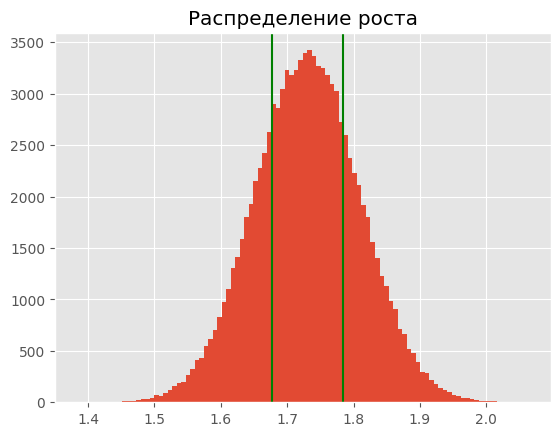

In [191]:
#в этой ячейке генерируем и рисуем рост
np.random.seed(1)
height = np.random.normal(loc=1.73, scale=0.08, size=100000)

plt.hist(height, 100)
plt.axvline(np.quantile(height, 0.75), color='green')
plt.axvline(np.quantile(height, 0.25), color='green')
print(np.quantile(height, 0.75), np.quantile(height, 0.25))
plt.title('Распределение роста')
plt.show()

79.022003470256 66.87901163194337


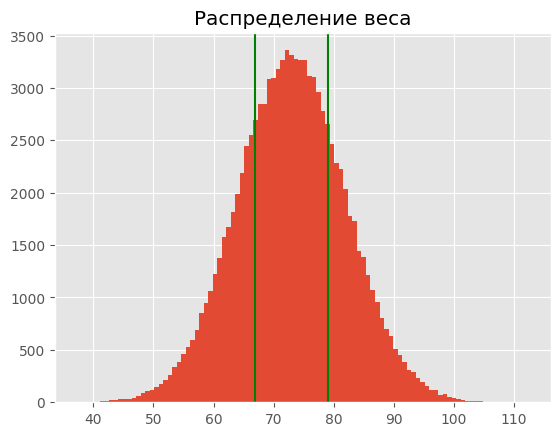

In [192]:
#в этой ячейке генерируем и рисуем вес
np.random.seed(2)
weight = np.random.normal(loc=73, scale=9, size=100000)

plt.hist(weight, 100)
plt.axvline(np.quantile(weight, 0.75), color='g')
plt.axvline(np.quantile(weight, 0.25), color='g')
print(np.quantile(weight, 0.75), np.quantile(weight, 0.25))
plt.title('Распределение веса')
plt.show()

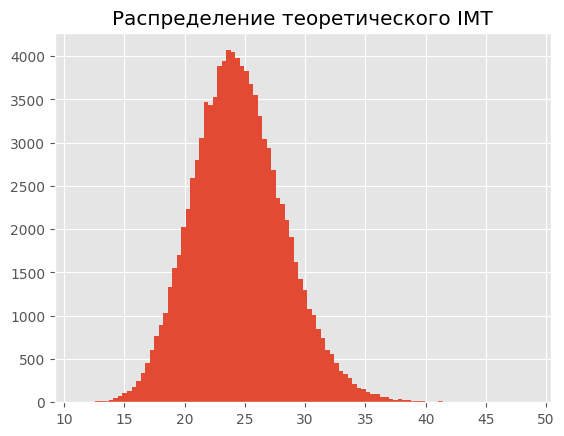

In [193]:
#в этой ячейке генерируем и рисуем индекс массы тела
IMT_theory = weight/height**2

plt.hist(IMT_theory, 100)
plt.title('Распределение теоретического IMT')
plt.show()

In [68]:
#так как реальные данные редко полностью описываются нормальным распределением, то добавим шумы, основываясь на имеющихся данных:
np.random.seed(3)
noise_1 = np.random.choice(np.random.uniform(5,45,10000), 2000)
noise_2 = np.random.choice(np.random.uniform(40,50,10000), 500)

IMT = np.concatenate((IMT_theory,noise_1, noise_2), axis=0)

plt.hist(IMT, 100)
plt.title('Распределение IMT')
plt.show()

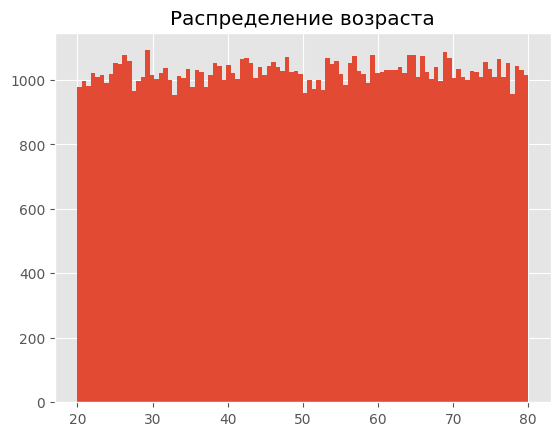

In [70]:
#теперь сгенерируем переменную возраст:
#предположим, что наша выборка сбалансированная и распределение равномерное от 20 до 80 лет:
np.random.seed(5)
age = np.random.uniform(20,80,102500)

plt.hist(age, 100)
plt.title("Распределение возраста")
plt.show()

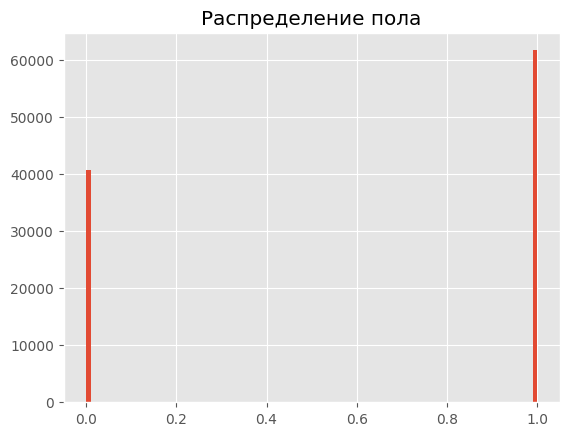

In [71]:
#теперь сгенерируем переменную пол:
#предположим, что выборка в целом сбалансированная, но с небольшим перекосом в сторону мужчин:
np.random.seed(6)
sex = np.random.binomial(n = 1, p = 0.6, size = 102500)

plt.hist(sex, 100)
plt.title("Распределение пола")
plt.show()

60764.57400514638


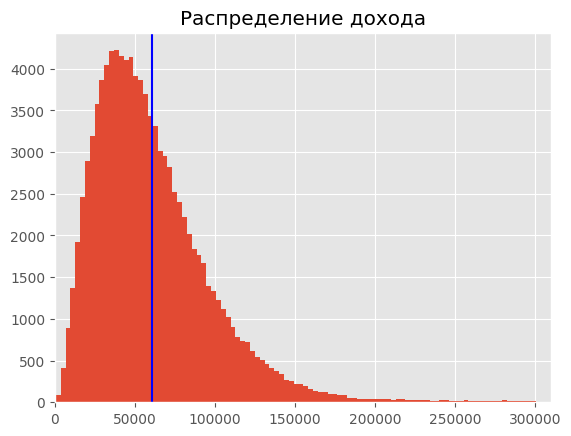

In [72]:
#теперь сгенерируем переменную доход:
#предположим, что распределение принадлежит гамма и добавим немного шумов:
np.random.seed(7)
alpha = 3.0  #числитель
beta = 1   #знаменатель

samples_raw = stats.gamma.rvs(alpha, scale=1.0/beta, size=102000)
samples_scaled = samples_raw*20000
noise_gamma = np.random.choice(np.random.uniform(200000,300000,10000), 500)
income = np.concatenate((samples_scaled, noise_gamma), axis=0)

plt.hist(income, 100)
plt.title('Распределение дохода')
plt.xlim(0,310000)
plt.axvline(np.mean(income), color='b')
print(np.mean(income))
plt.show()

In [236]:
#теперь сгенерируем переменную мотивации:
#предположим, что релевантное распределение это t-распределение и добавим немного шумов:
#основу кода взяли из консультации https://colab.research.google.com/drive/15l0cILQJZdi3RXKScGG8K0jjbLtbcS5G?usp=sharing#scrollTo=ZkoguR89Do_8:
np.random.seed(8)

motivation = t.rvs(size = 100000, df = 10)
motivation = (motivation) * 10 +50
motivation = np.round(np.abs(motivation) + 1) #abs, чтобы склонность была положительной

motivation[motivation <= 0] = 0
motivation = motivation[motivation <= 100] #дропнем выбросы
pred_noise_1 = np.random.uniform(10,90,int((102500 - len(motivation)))) #добавим шумы

motivation = np.concatenate((motivation,pred_noise_1), axis=0)
print(len(motivation))

102500


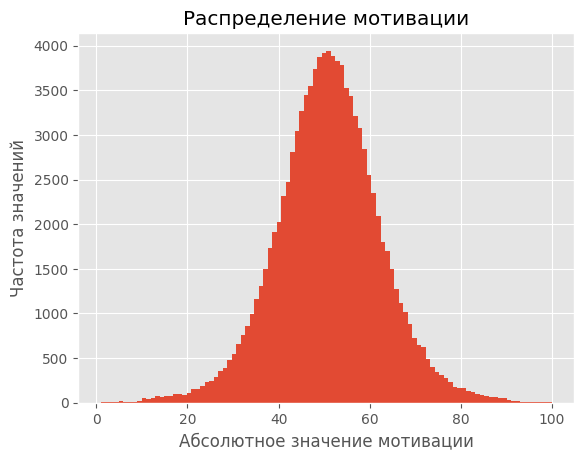

In [235]:
plt.hist(motivation, 100)
plt.title('Распределение мотивации')
plt.xlabel('Абсолютное значение мотивации')
plt.ylabel('Частота значений')
plt.show()

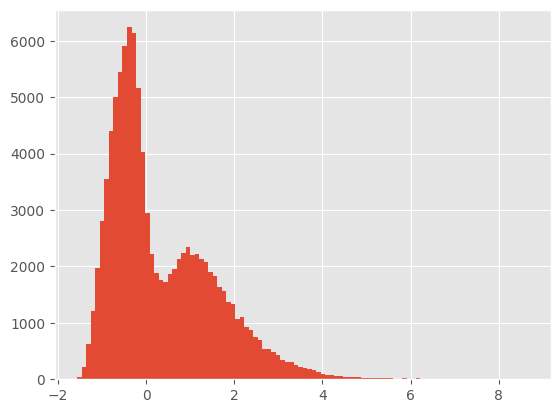

1.4409569993794384
0.5561365853658536


In [237]:
#теперь сгенерируем переменную жизнь рядом со спортивной инфраструктурой:
instr = 0.4 * (income/1000) / (70 - 0.5 * age) - sex * age / 50 + (1 - sex) * (income/1000) / 60
plt.hist(instr, 100)
plt.show()
instr_prob = norm.cdf(instr)
sport_infra = np.random.binomial(n = 1, p = instr_prob, size = 102500)
print(np.var(instr))
print(np.mean(sport_infra))

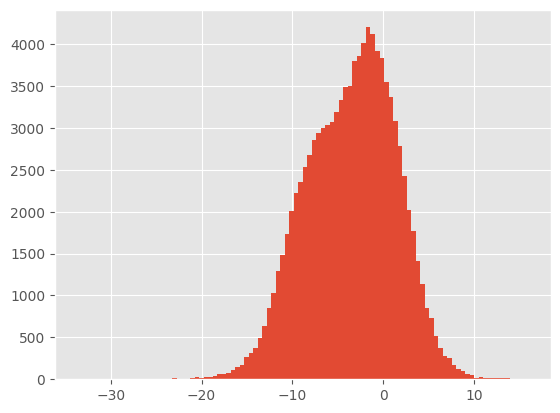

0.7940487804878049
0.2656780487804878
0.5476682926829268


In [238]:
#теперь сгенерируем переменную регулярные занятия спортом:
#основа кода взята с той же тетрадки с консультации
u = uniform.rvs(size = 102500)

sport_index = 9 * np.log(motivation + 1) + 1.2 * np.sqrt(income/1000) - 2 * (1 - sex) * age / 50 + 5 * sex - 50

plt.hist(sport_index, 100)
plt.show()

sport_infra_1 = 1
sport1_index = sport_index + 8 * sport_infra_1
sport1_prob = logistic.cdf(sport1_index)
sport1 = (sport1_prob >= u).astype(int)
print(np.mean(sport1))

sport_infra_0    = 0
sport0_index = sport_index + 8 * sport_infra_0
sport0_prob  = logistic.cdf(sport0_index, scale = 1)
sport0       = (sport0_prob >= u).astype(int)
print(np.mean(sport0))

regular_sport = sport1 * sport_infra + sport0 * (1 - sport_infra)
print(np.mean(regular_sport))

In [239]:
#посмотрим на разбиение на тейкеров, комплаеров и тд, а еще корреляции, основа кода взята из тетрадки с консы:
ind_type = np.empty(102500, dtype = 'U25')
ind_type[(sport1 == 1) & (sport0 == 1)] = 'Always taker'
ind_type[(sport1 == 0) & (sport0 == 0)] = 'Never taker'
ind_type[sport1 > sport0]               = 'Complier'
ind_type[sport1 < sport0]               = 'Denier'

print(pd.value_counts(ind_type))
print(pd.DataFrame(data    = [np.corrcoef(regular_sport, motivation)[0, 1],
                              np.corrcoef(regular_sport, sport_infra)[0, 1]],
                   index   = ['Corr(regular_sport, motivation)',
                              'Corr(regular_sport, sport_infra)'],
                   columns = ['Оценка']))

Complier        54158
Always taker    27232
Never taker     21110
Name: count, dtype: int64
                                    Оценка
Corr(regular_sport, motivation)   0.318308
Corr(regular_sport, sport_infra)  0.375063


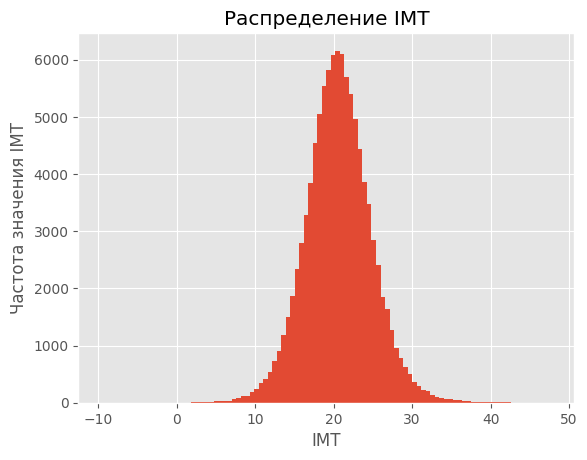

In [368]:
#теперь сгенерируем целевую переменную
error_0 = t.rvs(size = 102500, df = 5) * 2
chi2_right = chi2.rvs(df=2, size=int(102500/2))
chi2_left = [-x for x in chi2_right]
error_1 = np.concatenate((chi2_left, chi2_right), axis=0)

g0_obs   = 8 * (income/1000) / (120 - 0.5 * age - 10 * sex) + 3
g0_unobs =  0.3 * motivation
g0       = g0_obs + g0_unobs

g1_obs   = 6 * (income/1000) / (140 - 0.6 * age - 10 * sex) + 5
g1_unobs =  0.2 * motivation
g1       = g1_obs + g1_unobs

IMT_0 = g0 + error_0
IMT_1 = g1 + error_1

IMT = IMT_1 * regular_sport + IMT_0 * (1 - regular_sport)

plt.hist(IMT, 100)
plt.title('Распределение IMT')
plt.xlabel('IMT')
plt.ylabel('Частота значения IMT')
plt.show()

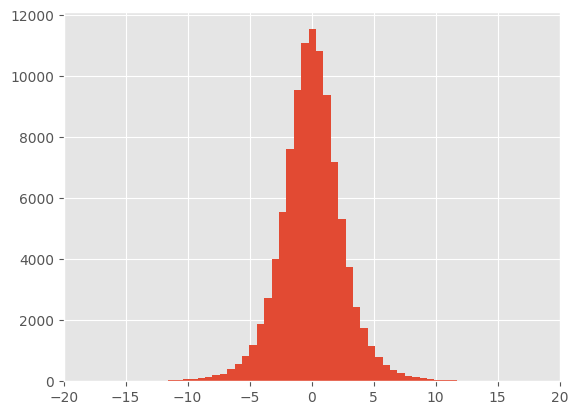

In [369]:
plt.hist(error_0, 100)
plt.xlim(-20,20)
plt.show()

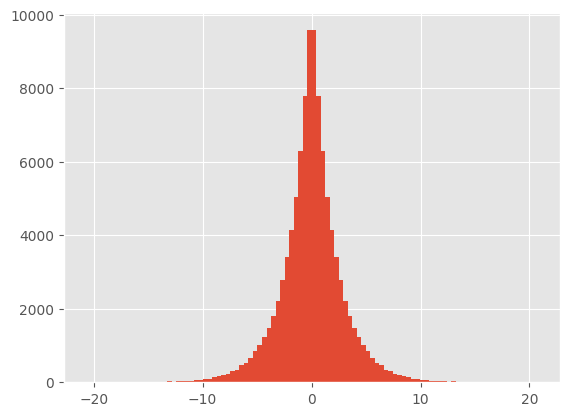

In [370]:
plt.hist(error_1, 100)
# plt.xlim(-20,20)
plt.show()

In [371]:
# Приблизительно оценим адекватность дисперсий
print(pd.DataFrame(data    = [np.var(error_0),   np.var(g0),
                              np.var(g0_obs),   np.var(g0_unobs),
                              np.var(error_1),   np.var(g1),
                              np.var(g1_obs),   np.var(g1_unobs)],
                   index   = ['Var(eps0)',     'Var(g0)',
                              'Var(g0_obs)',   'Var(g0_unobs)',
                              'Var(eps1)',     'Var(g1)',
                              'Var(g1_obs)',   'Var(g1_unobs)'],
                   columns = ['Оценка']))

                  Оценка
Var(eps0)       6.709331
Var(g0)        23.794440
Var(g0_obs)    11.819831
Var(g0_unobs)  12.040788
Var(eps1)       8.114291
Var(g1)        10.182307
Var(g1_obs)     4.859990
Var(g1_unobs)   5.351461


In [366]:
# Аггрегируем данные в датафрейм
df = pd.DataFrame({'IMT': IMT, 'regular_sport': regular_sport,
                   'age': age, 'sex': sex,
                   'income': income,'sport_infra': sport_infra})
df = df.loc[0:102500, :]

# Посмотрим на симулированные данные
df.head(10).style.format(precision = 2)

,IMT,regular_sport,age,sex,income,sport_infra
0,23.08,0,33.32,0,39517.32,1
1,20.25,0,72.24,1,31493.81,0
2,16.79,0,32.40,0,53400.82,0
3,21.59,1,75.12,1,93952.16,1
4,16.13,1,49.30,1,75447.75,1
5,16.83,1,56.70,1,71597.05,1
6,15.06,1,65.95,1,45244.75,0
7,16.59,0,51.11,1,73573.62,0
8,17.66,1,37.81,1,57482.44,1
9,22.32,1,31.26,0,127450.62,1


In [372]:
np.corrcoef(sport_infra, IMT)

array([[ 1.        , -0.11838506],
       [-0.11838506,  1.        ]])